In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("settled.csv")  # Replace with your file
target_col = 'Target_Variable/Total Income'


In [5]:
def remove_outliers_modified_z(df, threshold=3.5):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        median = df_clean[col].median()
        mad = np.median(np.abs(df_clean[col] - median))
        if mad == 0:
            continue  # Avoid division by zero
        modified_z_scores = 0.6745 * (df_clean[col] - median) / mad
        df_clean = df_clean[np.abs(modified_z_scores) < threshold]
    
    return df_clean

# Usage:
df_no_outliers = remove_outliers_modified_z(df)


C:\Users\HP\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\HP\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
df.shape

(30940, 105)

In [7]:
df_no_outliers.shape

(0, 105)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Step 1: Get numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Step 2: Count outliers using IQR method for each column
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outlier_counts = df[numeric_cols].apply(count_outliers_iqr)
top_10_outlier_cols = outlier_counts.sort_values(ascending=False).head(10).index.tolist()

# Step 3: Copy dataframe for transformation
df_transformed = df.copy()

# Step 4: Log1p transform highly skewed numeric columns
skewness = df[numeric_cols].skew().abs()
highly_skewed = skewness[skewness > 1].index.tolist()

for col in highly_skewed:
    if (df_transformed[col] >= 0).all():
        df_transformed[col] = np.log1p(df_transformed[col])

# Step 5: Apply RobustScaler to all numeric columns
scaler = RobustScaler()
df_transformed[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])

# Step 6: Plot boxplots for the top 10 outlier columns (after transformation)
#plt.figure(figsize=(18, 10))
#for i, col in enumerate(top_10_outlier_cols, 1):
    #plt.subplot(2, 5, i)
   # sns.boxplot(y=df_transformed[col])
   # plt.title(col)
   # plt.tight_layout()

#plt.suptitle("Top 10 Outlier Columns After Log1p + RobustScaler", fontsize=16, y=1.02)
#plt.show()


In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Print the list
print("Total numeric columns:", len(numeric_cols))
print("Numeric columns:\n", numeric_cols)

Total numeric columns: 67
Numeric columns:
 ['FarmerID', 'Zipcode', 'No_of_Active_Loan_In_Bureau', 'Avg_Disbursement_Amount_Bureau', 'Non_Agriculture_Income', 'Total_Land_For_Agriculture', 'K022-Proximity to nearest mandi (Km)', 'K022-Proximity to nearest railway (Km)', 'KO22-Village score based on socio-economic parameters (0 to 100)', 'K022-Seasonal Average Rainfall (mm)', 'R022-Seasonal Average Rainfall (mm)', 'K021-Seasonal Average Rainfall (mm)', 'R021-Seasonal Average Rainfall (mm)', 'R020-Seasonal Average Rainfall (mm)', 'Perc_of_house_with_6plus_room', 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey', 'perc_of_pop_living_in_hh_electricity', 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms', 'mat_roof_Metal_GI_Asbestos_sheets', 'perc_of_Wall_material_with_Burnt_brick', 'Households_with_improved_Sanitation_Facility', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'K022-Total Geographical Area (in Hectares)-', 'K022-Net Agri area (in Ha)-', 'K022-Ne

In [10]:
df.set_index('FarmerID', inplace=True)

In [11]:
df.head()

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
FarmerID,,,,,,,,,,,,,,,,,,,,,
1032447758966470,MADHYA PRADESH,CENTRAL,M,VIDISHA,464001,VIDISHA,Ambar,M,"23.5131479,77.8207876",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,100.95,25.95,0.95,22.33,33.45,Poor,1.96,0.00,800000
1041885888252080,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Khapar Kheda,M,"22.7184042,78.2180971",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,82.60,22.76,0.94,27.94,42.54,Average,0.48,3.89,700000
1068465784357340,ODISHA,EAST,M,RAMGARH,754022,CUTTACK,Karanji,S,"20.649898,85.9164129",Permanent Address,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,91.92,17.60,0.95,26.98,40.98,Poor,0.34,0.00,1295000
1072440196043140,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Pondi,M,"22.7472362,78.3550004",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,96.85,19.01,0.93,24.97,37.73,Poor,0.35,0.00,800000
1073642021022590,MADHYA PRADESH,CENTRAL,M,ASHOKNAGAR,473330,ASHOKNAGAR,Amoda,M,"24.8491952,77.6157991",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,93.67,19.70,0.91,29.20,44.58,Average,0.82,0.00,750000


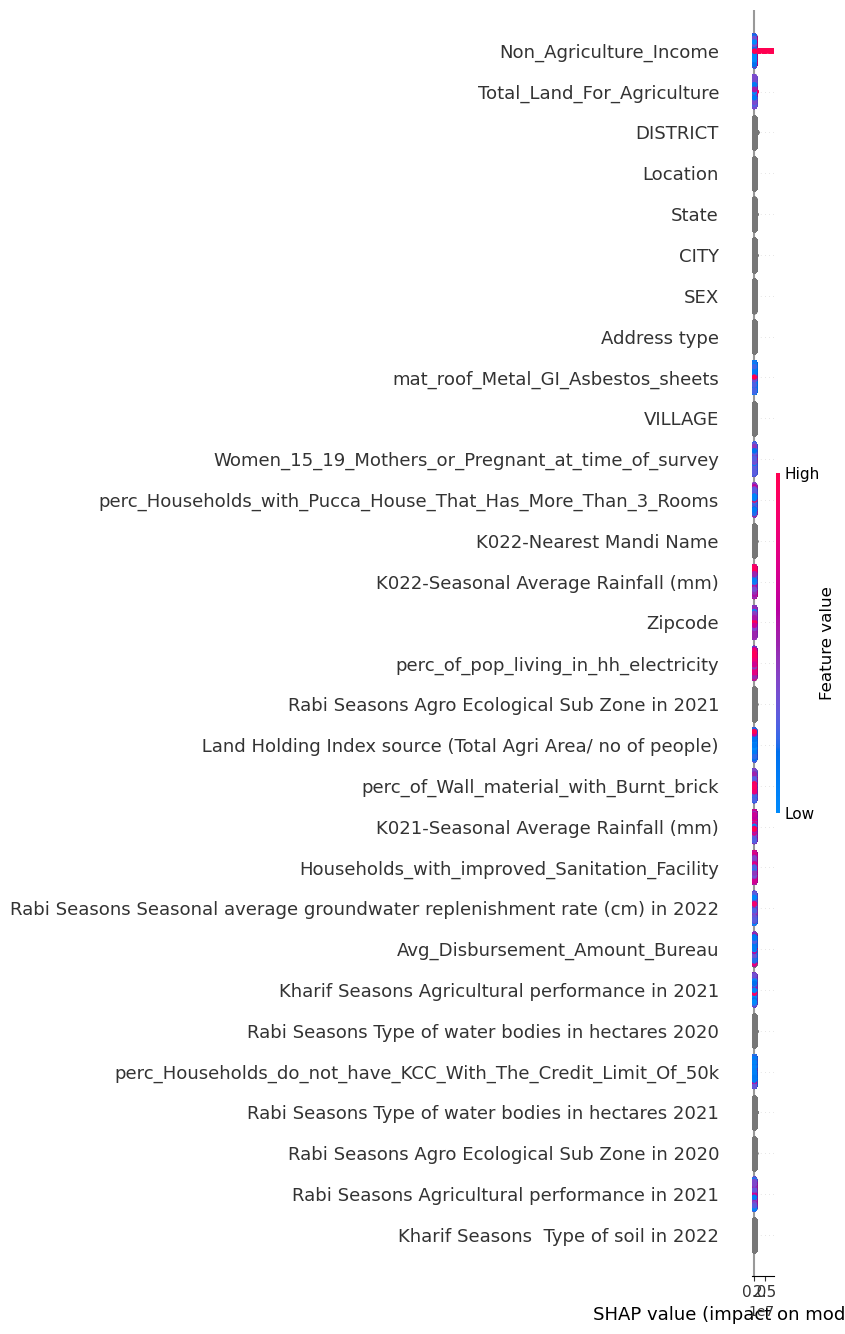

Top 50 Features by SHAP:
['Non_Agriculture_Income', 'Total_Land_For_Agriculture', 'DISTRICT', 'Location', 'State', 'CITY', 'SEX', 'Address type', 'mat_roof_Metal_GI_Asbestos_sheets', 'VILLAGE', 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey', 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms', 'K022-Nearest Mandi Name', 'K022-Seasonal Average Rainfall (mm)', 'Zipcode', 'perc_of_pop_living_in_hh_electricity', 'Rabi Seasons Agro Ecological Sub Zone in 2021', ' Land Holding Index source (Total Agri Area/ no of people)', 'perc_of_Wall_material_with_Burnt_brick', 'K021-Seasonal Average Rainfall (mm)', 'Households_with_improved_Sanitation_Facility', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Avg_Disbursement_Amount_Bureau', 'Kharif Seasons Agricultural performance in 2021', 'Rabi Seasons Type of water bodies in hectares 2020', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'Rabi Seasons Type of water bodies in hectares 2021',

In [12]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt

# 1. Split numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)


In [13]:
df_top50 = df[top_features + ['Target_Variable/Total Income']]


In [14]:
# 1. Average income per village
df['village_income_avg'] = df.groupby('VILLAGE')['Target_Variable/Total Income'].transform('mean')

# 2. Income vs village average (how much better or worse this farmer is)
df['income_vs_village_avg'] = df['Target_Variable/Total Income'] / df['village_income_avg']

# 3. District-level average number of active loans
df['district_loan_avg'] = df.groupby('DISTRICT')['No_of_Active_Loan_In_Bureau'].transform('mean')

# 4. Farmer's loan burden compared to district average
df['loan_burden_vs_district'] = df['No_of_Active_Loan_In_Bureau'] / df['district_loan_avg']

# 5. District-level average mandi distance (proximity to markets)
df['district_mandi_avg_dist'] = df.groupby('DISTRICT')['K022-Proximity to nearest mandi (Km)'].transform('mean')


In [15]:
df.head()

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income,village_income_avg,income_vs_village_avg,district_loan_avg,loan_burden_vs_district,district_mandi_avg_dist
FarmerID,,,,,,,,,,,,,,,,,,,,,
1032447758966470,MADHYA PRADESH,CENTRAL,M,VIDISHA,464001,VIDISHA,Ambar,M,"23.5131479,77.8207876",Permanent Address,...,33.45,Poor,1.96,0.00,800000,2.261130e+06,0.353805,3.973890,0.000000,14.881984
1041885888252080,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Khapar Kheda,M,"22.7184042,78.2180971",Permanent Address,...,42.54,Average,0.48,3.89,700000,7.375000e+05,0.949153,2.097087,0.000000,12.578155
1068465784357340,ODISHA,EAST,M,RAMGARH,754022,CUTTACK,Karanji,S,"20.649898,85.9164129",Permanent Address,...,40.98,Poor,0.34,0.00,1295000,8.492222e+05,1.524925,2.638889,0.378947,13.194444
1072440196043140,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Pondi,M,"22.7472362,78.3550004",Permanent Address,...,37.73,Poor,0.35,0.00,800000,1.141919e+06,0.700575,2.097087,0.476852,12.578155
1073642021022590,MADHYA PRADESH,CENTRAL,M,ASHOKNAGAR,473330,ASHOKNAGAR,Amoda,M,"24.8491952,77.6157991",Permanent Address,...,44.58,Average,0.82,0.00,750000,1.474690e+06,0.508581,0.821803,0.000000,5.861426


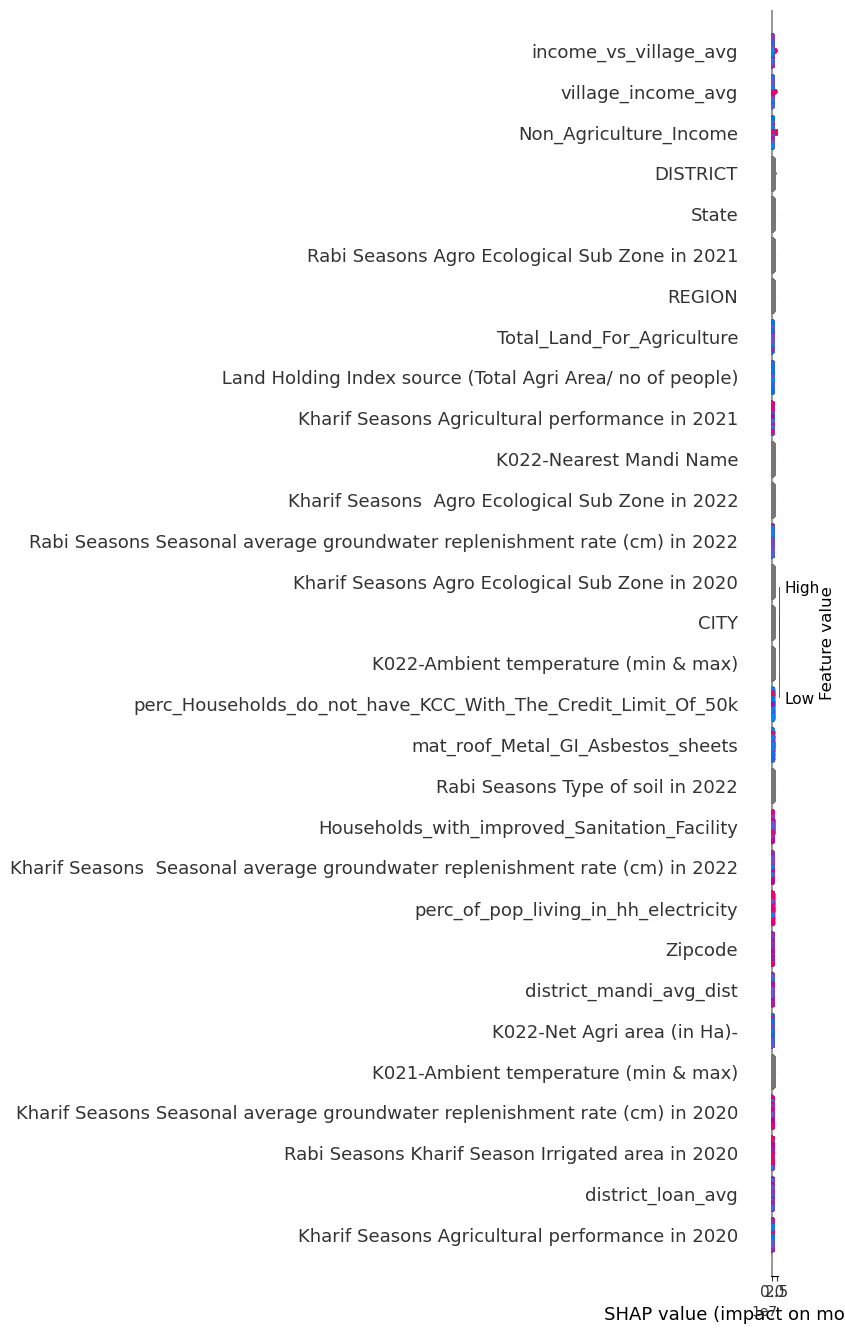

Top 50 Features by SHAP:
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'DISTRICT', 'State', 'Rabi Seasons Agro Ecological Sub Zone in 2021', 'REGION', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'Kharif Seasons Agricultural performance in 2021', 'K022-Nearest Mandi Name', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agro Ecological Sub Zone in 2020', 'CITY', 'K022-Ambient temperature (min & max)', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'mat_roof_Metal_GI_Asbestos_sheets', 'Rabi Seasons Type of soil in 2022', 'Households_with_improved_Sanitation_Facility', 'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022', 'perc_of_pop_living_in_hh_electricity', 'Zipcode', 'district_mandi_avg_dist', 'K022-Net Agri area (in Ha)-', 'K021-Ambient temperature (min & max)', 'Kharif 

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)

In [17]:
# Step 1: Groundwater Replenishment Average
df['avg_groundwater_replenishment'] = df[[
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020',
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021',
    'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022'
]].mean(axis=1)

# Step 2: Kharif Agricultural Score Average
df['kharif_agri_score_avg'] = df[[
    'Kharif Seasons Agricultural Score in 2020',
    'Kharif Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 3: Rabi Agricultural Score Average
df['rabi_agri_score_avg'] = df[[
    'Rabi Seasons Agricultural Score in 2020',
    'Rabi Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 4: Average Seasonal Rainfall
df['avg_rainfall'] = df[[
    'K021-Seasonal Average Rainfall (mm)',
    'R022-Seasonal Average Rainfall (mm)',
    'K022-Seasonal Average Rainfall (mm)'
]].mean(axis=1)

# Step 5: Total Agri Performance Score (Kharif + Rabi)
df['total_agri_performance'] = df[[
    'Kharif Seasons Agricultural performance in 2020',
    'Kharif Seasons Agricultural performance in 2021',
    'Kharif Seasons  Agricultural performance in 2022',
    'Rabi Seasons Agricultural performance in 2020'
]].mean(axis=1)

# Step 6: Combined Soil Feature (2022 only)
df['soil_type_encoded'] = df[[
    'Kharif Seasons  Type of soil in 2022',
    'Rabi Seasons Type of soil in 2022'
]].astype(str).agg('_'.join, axis=1)

# (Optional) encode soil_type_encoded using LabelEncoder if model needs numeric input
from sklearn.preprocessing import LabelEncoder
df['soil_type_encoded'] = LabelEncoder().fit_transform(df['soil_type_encoded'])

# Step 7: Village Socio-Economic Score Adjusted
df['socio_econ_adjusted'] = df[
    'KO22-Village score based on socio-economic parameters (0 to 100)'
] * (df['perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms'] / 100 + 1)


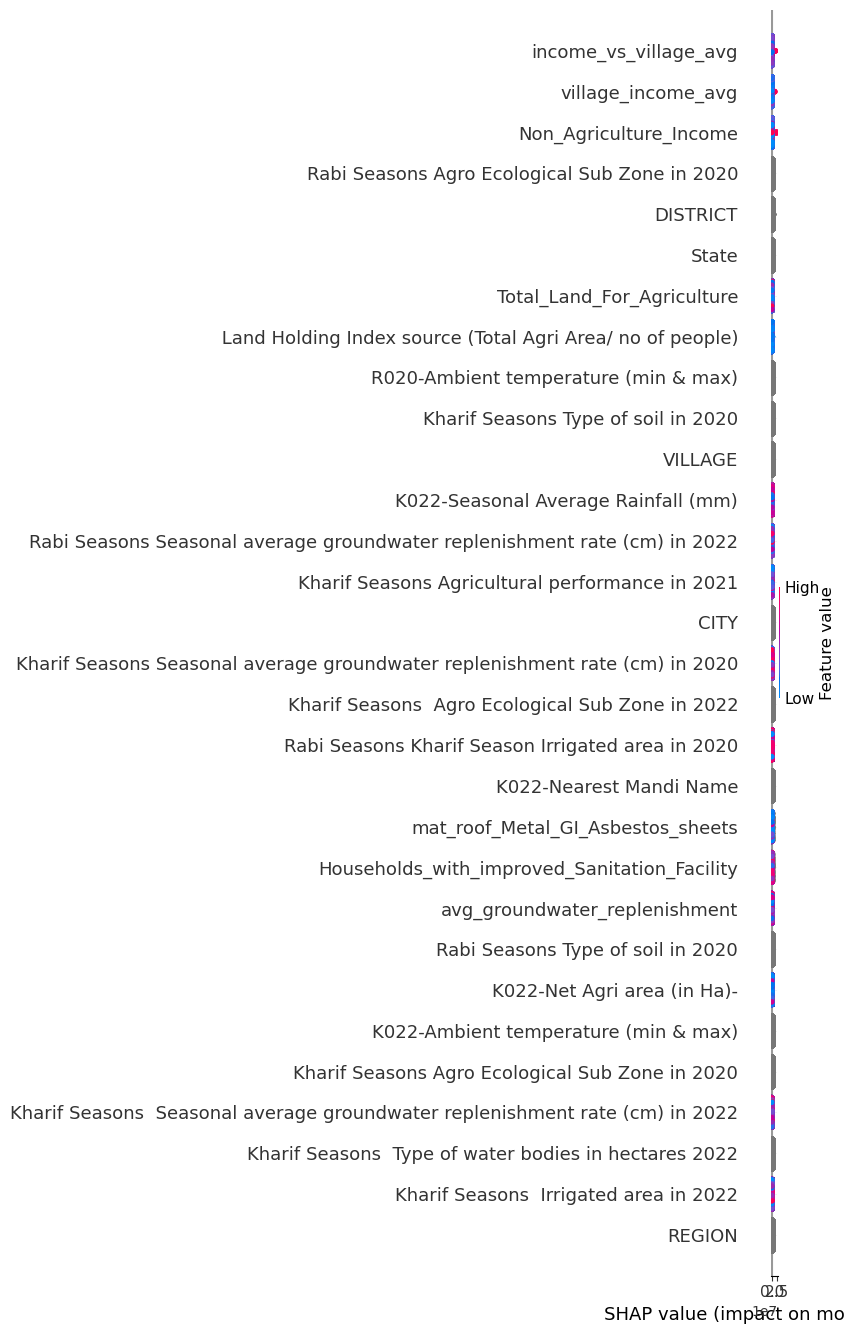

Top 50 Features by SHAP:
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'Rabi Seasons Agro Ecological Sub Zone in 2020', 'DISTRICT', 'State', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'R020-Ambient temperature (min & max)', 'Kharif Seasons Type of soil in 2020', 'VILLAGE', 'K022-Seasonal Average Rainfall (mm)', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agricultural performance in 2021', 'CITY', 'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Kharif Season Irrigated area in 2020', 'K022-Nearest Mandi Name', 'mat_roof_Metal_GI_Asbestos_sheets', 'Households_with_improved_Sanitation_Facility', 'avg_groundwater_replenishment', 'Rabi Seasons Type of soil in 2020', 'K022-Net Agri area (in Ha)-', 'K022-Ambient temperature (min & max)', 'Kharif Seasons Agro Ecological Sub Z

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)

In [19]:
import numpy as np
import pandas as pd

# Use your existing SHAP importance
shap_df = shap_importance  # Already a Series with index = feature names

# Step 1: Take top 50 features
top_50_features = shap_df.head(50).index.tolist()

# Step 2: Subset numeric columns only
numeric_top_50 = df[top_50_features].select_dtypes(include=[np.number])

# Step 3: Correlation matrix
corr_matrix = numeric_top_50.corr().abs()

# Step 4: Extract upper triangle (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 5: Find highly correlated pairs (r > 0.85)
correlated_pairs = [
    (col1, col2)
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col2, col1] > 0.85
]

# Step 6: Drop the one with lower SHAP score
shap_scores = shap_df.to_dict()
features_to_drop = set()

for col1, col2 in correlated_pairs:
    if shap_scores.get(col1, 0) >= shap_scores.get(col2, 0):
        features_to_drop.add(col2)
    else:
        features_to_drop.add(col1)

# Step 7: Final filtered features
final_features = [f for f in top_50_features if f not in features_to_drop]

# Output
print(f"Dropped {len(features_to_drop)} correlated features:")
print(sorted(features_to_drop))

print(f"\nFinal top features after removing correlations: {len(final_features)}")
print(final_features)



Dropped 2 correlated features:
['K022-Total Geographical Area (in Hectares)-', 'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022']

Final top features after removing correlations: 48
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'Rabi Seasons Agro Ecological Sub Zone in 2020', 'DISTRICT', 'State', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'R020-Ambient temperature (min & max)', 'Kharif Seasons Type of soil in 2020', 'VILLAGE', 'K022-Seasonal Average Rainfall (mm)', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agricultural performance in 2021', 'CITY', 'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Kharif Season Irrigated area in 2020', 'K022-Nearest Mandi Name', 'mat_roof_Metal_GI_Asbestos_sheets', 'Households_with_improved_Sanitation_Fac

In [20]:
!pip install lightgbm


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# Target column
target_col = 'Target_Variable/Total Income'

# Use only available columns from final_features
valid_features = [col for col in final_features if col in df.columns]
X = df[valid_features]
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_cols)
    ]
)

# XGBoost pipeline
model = xgb.XGBRegressor(random_state=42)
pipeline = make_pipeline(preprocessor, model)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Scores
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to %

print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


R² Score: 0.9057
MAPE: 2.68%


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Target column
target_col = 'Target_Variable/Total Income'

# Use only available columns from final_features
valid_features = [col for col in final_features if col in df.columns]
X = df[valid_features]
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_cols)
    ]
)

# Random Forest pipeline
model = RandomForestRegressor(random_state=42, n_jobs=-1)
pipeline = make_pipeline(preprocessor, model)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Scores
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to %

print(f"R² Score (Random Forest): {r2:.4f}")
print(f"MAPE (Random Forest): {mape:.2f}%")


R² Score (Random Forest): 0.9441
MAPE (Random Forest): 0.69%


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor

# Target column
target_col = 'Target_Variable/Total Income'

# Use only available columns from final_features
valid_features = [col for col in final_features if col in df.columns]
X = df[valid_features]
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_cols)
    ]
)

# LightGBM pipeline
model = LGBMRegressor(random_state=42, n_jobs=-1)
pipeline = make_pipeline(preprocessor, model)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Scores
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to %

print(f"R² Score (LightGBM): {r2:.4f}")
print(f"MAPE (LightGBM): {mape:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12850
[LightGBM] [Info] Number of data points in the train set: 24752, number of used features: 2456
[LightGBM] [Info] Start training from score 1186393.769110
R² Score (LightGBM): 0.9075
MAPE (LightGBM): 1.96%


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

# Target column
target_col = 'Target_Variable/Total Income'

# Use only available columns from final_features
valid_features = [col for col in final_features if col in df.columns]
X = df[valid_features]
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# Fill missing values (CatBoost can handle some missing, but better to impute)
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].mean())
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].mean())
X_train[cat_cols] = X_train[cat_cols].fillna('missing')
X_test[cat_cols] = X_test[cat_cols].fillna('missing')

# CatBoost model
model = CatBoostRegressor(
    random_state=42,
    verbose=0,  # turn off training logs
)

# Fit model (with categorical features specified)
model.fit(X_train, y_train, cat_features=cat_cols)

# Predict
y_pred = model.predict(X_test)

# Scores
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to %

print(f"R² Score (CatBoost): {r2:.4f}")
print(f"MAPE (CatBoost): {mape:.2f}%")


R² Score (CatBoost): 0.9006
MAPE (CatBoost): 1.81%
